In [1]:
import os
import sqlite3
import random
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pickle

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [3]:
def compile_observed_traveltime_data(directory, target_msoas, period):
    '''Scans all subdirectories to find db files containing observed travel time data and compiles observed fastest travel 
    times for all trips ending in the target_msoas.
    directory is a path to the directory containing the observed travel time data, target_msoas is a list containing 
    MSOA IDs and period is "ampeak" or "offpeak".'''
    output = dict()
    directories = [x[0] for x in os.walk(directory) if x[0][-6:] == period[-6:]] # list all directories, considering only data for specified period
    for directory in directories:
        dbfile = [f for f in os.listdir(directory) if f[-3:] == '.db'][0] # find all db files
        db = sqlite3.connect(directory + '/' + dbfile)
        for msoa in target_msoas:
            # excluding cycling options as cycling tends to suppress SD travel time
            traveltimes = pd.read_sql('SELECT orig_id, option_id, traveltime FROM traveloptions WHERE dest_id == "' + msoa + '" AND legs_cycle == 0',
                                     db, index_col = ['orig_id','option_id'])
            if len(traveltimes) > 0:
                min_traveltimes = traveltimes.groupby('orig_id').min()
                for orig in min_traveltimes.index:
                    currentkey = orig + '-' + msoa
                    try:
                        output[currentkey].append(min_traveltimes.loc[orig,'traveltime'])
                    except KeyError:
                        output[currentkey] = [min_traveltimes.loc[orig,'traveltime']]
        db.close()
    return output

In [4]:
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

In [5]:
traveltime_cutoff = 45

### Detection of Cluster Centroids

In [6]:
# read in minimum travel time data
db = sqlite3.connect('../../../../../data/London/TfL/TfL API/Journey Planner/ttm_ampeak.db')
old_baseline_fastestoption_ampeak = pd.read_sql("SELECT orig_id, dest_id, min_traveltime FROM ttm", db)
db.close()

# convert travel time matrix from long-form to wide-form
old_ttm_baseline_ampeak = pd.pivot_table(old_baseline_fastestoption_ampeak, values = 'min_traveltime', index = 'orig_id', 
                                         columns = 'dest_id', fill_value = np.max(old_baseline_fastestoption_ampeak['min_traveltime'])*2) # to fill in missing traveltime values

In [7]:
# randomly permutate the order of MSOAs by the same order in rows and columns
index_randperm = old_ttm_baseline_ampeak.sample(frac = 1).index
ttm_baseline_ampeak_randperm = old_ttm_baseline_ampeak.loc[index_randperm,index_randperm]

# calculate cosine similarity between row vectors of travel times
cosine_sim_ttm_baseline_ampeak_randperm = cosine_similarity(ttm_baseline_ampeak_randperm)

C:\Users\Daniel Leong\Anaconda3\lib\site-packages\sklearn\cluster\bicluster.py:296: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in range(self.n_clusters))
C:\Users\Daniel Leong\Anaconda3\lib\site-packages\sklearn\cluster\bicluster.py:298: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in range(self.n_clusters))


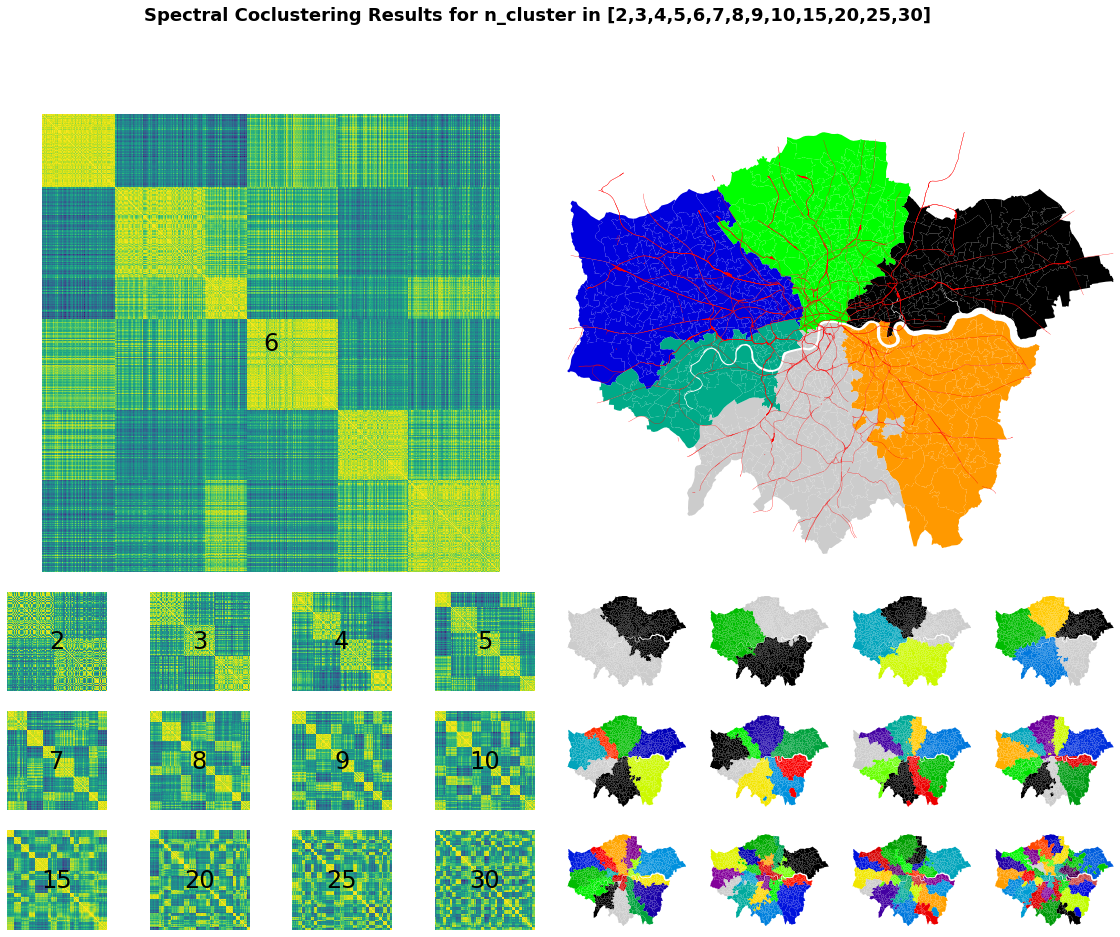

In [8]:
# calculate spectral coclustering for variety of number of clusters
n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30]
clustering = {'fitdata': [], 'clustered_msoas': []}
plottingsettings = {'grid_rows': 7,
                    'grid_cols': 8,
                    'grid_pos': [[[4,5],[0,1]], # position of each plot generated from n_clusters in the GridSpec
                                 [[4,5],[1,2]],
                                 [[4,5],[2,3]],
                                 [[4,5],[3,4]],
                                 [[0,4],[0,4]],
                                 [[5,6],[0,1]],
                                 [[5,6],[1,2]],
                                 [[5,6],[2,3]],
                                 [[5,6],[3,4]],
                                 [[6,7],[0,1]],
                                 [[6,7],[1,2]],
                                 [[6,7],[2,3]],
                                 [[6,7],[3,4]]
                                ]
                   }

for n in n_clusters:
    # fitting spectral coclustering model
    model = SpectralCoclustering(n_clusters = n, n_svd_vecs=1)
    model.fit(cosine_sim_ttm_baseline_ampeak_randperm)

    fit_data = cosine_sim_ttm_baseline_ampeak_randperm[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]
    clustering['fitdata'].append(fit_data)
    
    # assigning clustering to spatial data
    clusters = np.dstack((index_randperm, model.row_labels_))[0]
    clusters = clusters[np.argsort(index_randperm)]

    clustered_msoa = pd.DataFrame({'cluster' : clusters[:,1]}, index = old_ttm_baseline_ampeak.index)
    clustered_msoa = msoas.join(clustered_msoa)
    clustering['clustered_msoas'].append(clustered_msoa)

# setting up plot
fig3 = plt.figure(figsize = (20,15))
gs3 = GridSpec(plottingsettings['grid_rows'],plottingsettings['grid_cols'], figure = fig3)
plt.suptitle('Spectral Coclustering Results for n_cluster in [2,3,4,5,6,7,8,9,10,15,20,25,30]', size = 18, weight = 'bold')

for plot in range(len(n_clusters)):
    # plot matrix in corresponding grid location specified in grid_pos
    current_ax = fig3.add_subplot(gs3[plottingsettings['grid_pos'][plot][0][0]:plottingsettings['grid_pos'][plot][0][1],
                                    plottingsettings['grid_pos'][plot][1][0]:plottingsettings['grid_pos'][plot][1][1]])
    current_ax.imshow(clustering['fitdata'][plot])
    current_ax.text(0.5, 0.5, n_clusters[plot], fontsize = 24, va = 'center', ha = 'center', transform = current_ax.transAxes)
    plt.axis('off')
    
    # plot map in corresponding grid location 4 columns over
    current_map = fig3.add_subplot(gs3[plottingsettings['grid_pos'][plot][0][0]:plottingsettings['grid_pos'][plot][0][1],
                                    plottingsettings['grid_pos'][plot][1][0]+4:plottingsettings['grid_pos'][plot][1][1]+4])
    set_zoom(current_map, msoas)
    clustering['clustered_msoas'][plot].plot(column = 'cluster', linewidth = 0, cmap = 'nipy_spectral', categorical = True, ax = current_map)
    
    if plot == 4:
        # overlay rail and tube map only on main figure
        londontube.plot(ax = current_map, color = 'red', linewidth = 0.3)
        londonrail.plot(ax = current_map, color = 'red', linewidth = 0.3)
    
    plt.axis('off')

In [9]:
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)

In [10]:
# use clustering for n = 6
clustered_msoas = clustering['clustered_msoas'][4][['cluster']]

# join clustering data to long-form ttm
cluster_centroid_detection_data = old_baseline_fastestoption_ampeak[['orig_id','dest_id','min_traveltime']].merge(clustered_msoas, left_on = 'orig_id', right_index = True)
cluster_centroid_detection_data = cluster_centroid_detection_data.merge(clustered_msoas, left_on = 'dest_id', right_index = True, suffixes = ('_orig', '_dest'))

# retain only pairs where origin and destination are in the same cluster
cluster_centroid_detection_data = cluster_centroid_detection_data[cluster_centroid_detection_data['cluster_orig'] == cluster_centroid_detection_data['cluster_dest']]
# join pop counts
cluster_centroid_detection_data = cluster_centroid_detection_data.merge(popcounts[['Pop_WorkingAge']], how = 'left', left_on = 'dest_id', right_index = True)
# calculate mean traveltime to from all origins in same cluster, weighted by number of pop in origins
cluster_centroid_detection_data['traveltime_x_pop'] = cluster_centroid_detection_data['min_traveltime'] * cluster_centroid_detection_data['Pop_WorkingAge']
msoa_popwtd_mean_traveltime_to_jobs = cluster_centroid_detection_data.groupby('dest_id').sum()
msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] = msoa_popwtd_mean_traveltime_to_jobs['traveltime_x_pop'] / msoa_popwtd_mean_traveltime_to_jobs['Pop_WorkingAge']
# rejoin destination-based clustering data
msoa_popwtd_mean_traveltime_to_jobs = msoa_popwtd_mean_traveltime_to_jobs.join(clustered_msoas)
# obtain minimum jobs-weighted mean traveltimes for each cluster
cluster_min_popwtd_mean_traveltime_to_jobs = msoa_popwtd_mean_traveltime_to_jobs.groupby('cluster').min()[['Pop Weighted Mean Traveltime']]
cluster_min_popwtd_mean_traveltime_to_jobs

Pop Weighted Mean Traveltime
cluster                              
0                           36.541401
1                           43.419689
2                           37.078652
3                           35.653061
4                           40.966887
5                           39.121827

In [11]:
# identify which MSOAs have the minimum mean pop-weighted travel times from origins in the same cluster
cluster_centroids = msoa_popwtd_mean_traveltime_to_jobs.loc[((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 0) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[0,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 1) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[1,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 2) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[2,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 3) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[3,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 4) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[4,'Pop Weighted Mean Traveltime'])) |
                                                            ((msoa_popwtd_mean_traveltime_to_jobs['cluster'] == 5) & (msoa_popwtd_mean_traveltime_to_jobs['Pop Weighted Mean Traveltime'] == cluster_min_popwtd_mean_traveltime_to_jobs.loc[5,'Pop Weighted Mean Traveltime']))].index


Working-Age Pop-Weighted Mean Travel Time
from all MSOAs in the same Cluster to each MSOA


(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

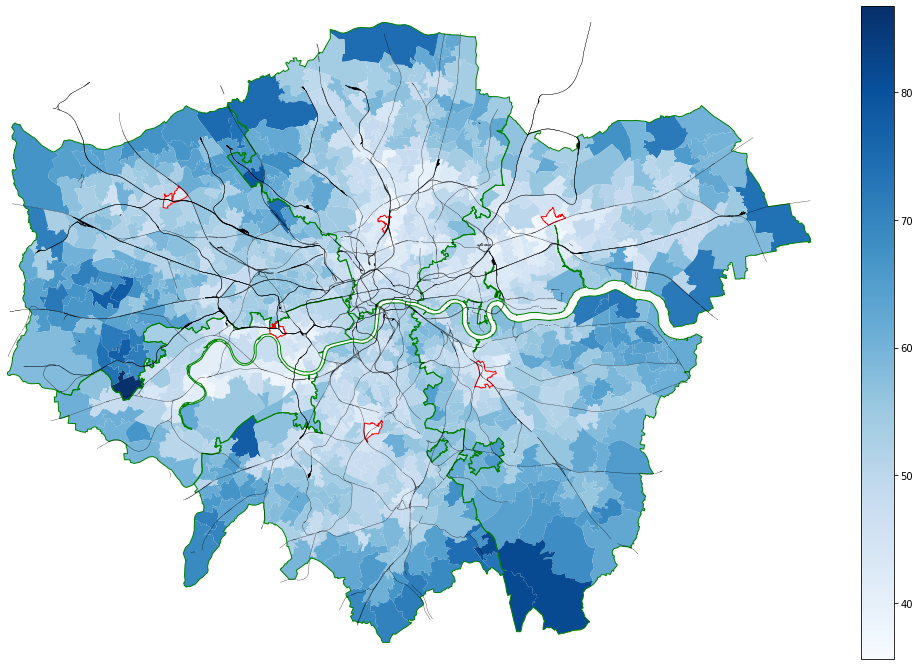

In [13]:
# plot map
fig01 = plt.figure(figsize = (18,12))
ax01_01 = fig01.add_subplot(111)
set_zoom(ax01_01, msoas)
# plot weighted mean traveltimes from cluster origins to each MSOA destination
msoas.join(msoa_popwtd_mean_traveltime_to_jobs).plot(column = 'Pop Weighted Mean Traveltime', cmap = 'Blues', legend = True, ax = ax01_01)
msoas.join(msoa_popwtd_mean_traveltime_to_jobs).dissolve(by = 'cluster').buffer(1).plot(ax = ax01_01, color = 'None', edgecolor = 'green')
msoas.loc[cluster_centroids, :].plot(ax = ax01_01, color = 'None', edgecolor = 'red')
londontube.plot(ax = ax01_01, color = 'black', linewidth = .3)
londonrail.plot(ax = ax01_01, color = 'black', linewidth = .3)
print('Working-Age Pop-Weighted Mean Travel Time\nfrom all MSOAs in the same Cluster to each MSOA')
plt.axis('off')

### Travel Time Variability to 7 Destinations from 5 Significant Origins

In [38]:
# add City to centroids list
cluster_centroids = list(cluster_centroids)
cluster_centroids.append('E02000001')
cluster_centroids

['E02000384',
 'E02000455',
 'E02000558',
 'E02000649',
 'E02000664',
 'E02000779',
 'E02000001']

In [39]:
centroid_names = {cluster_centroids[0]: 'Hammersmith',
                  cluster_centroids[1]: 'Harrow-on-the-Hill',
                  cluster_centroids[2]: 'Finsbury Park',
                  cluster_centroids[3]: 'Streatham',
                  cluster_centroids[4]: 'Lewisham',
                  cluster_centroids[5]: 'Ilford',
                  cluster_centroids[6]: 'City'}

In [40]:
# compile observed travel times for all trips ending in the 7 centroids
observed_traveltimes = {centroid: {'rawdata': compile_observed_traveltime_data('../../../../../data/London/TfL/TfL API/Travel Options/', [centroid], 'ampeak')} for centroid in cluster_centroids}

In [55]:
for centroid in cluster_centroids:
    observed_traveltimes[centroid]['traveltime_variability'] = pd.DataFrame(columns = ['orig_id','dest_id','Median', '5PC', '95PC', 'Range 5PC to 95PC', 'Interquartile Range'])
    for pair in observed_traveltimes[centroid]['rawdata'].keys():
        observed_traveltimes[centroid]['traveltime_variability'] = observed_traveltimes[centroid]['traveltime_variability'].append({'orig_id': pair.split('-')[0],
                                                                                                                                    'dest_id': pair.split('-')[1], 
                                                                                                                                    'Median': np.median(observed_traveltimes[centroid]['rawdata'][pair]),
                                                                                                                                    '5PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .05),
                                                                                                                                    '95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95),
                                                                                                                                    'Range 5PC to 95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .05),
                                                                                                                                    'Range 50PC to 95PC': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .95) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .5),
                                                                                                                                    'Interquartile Range': np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .75) - np.quantile(observed_traveltimes[centroid]['rawdata'][pair], .25)},
                                                                                                                                    ignore_index = True)
    observed_traveltimes[centroid]['traveltime_variability'].set_index('orig_id', inplace = True)
    observed_traveltimes[centroid]['traveltime_variability'] = msoas.join(observed_traveltimes[centroid]['traveltime_variability'])

In [42]:
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)
imd_msoa = imd_msoa.loc[msoas.index,:]

In [43]:
origins = ['E02000001', 'E02006801', 'E02000726'] # City, Waterloo (best Reach), Stratford (most populous)
origins.extend(imd_msoa.sort_values(by = 'Index of Multiple Deprivation (IMD) Rank').iloc[[0,-1],:].index) # most and least deprived MSOAs by IMD Rank

origin_names = {'E02000001': 'City', 'E02006801': 'Best Reach: Waterloo', 'E02000726': 'Most Populous: Stratford', 'E02000398': 'Most Deprived: Northumberland Park', 'E02000482': 'Least Deprived: Upminster'}

In [44]:
swarmdata = pd.DataFrame({'Origin': [], 'Destination': [], 'Observed Minus Median Travel Time': []})
for orig in origins:
    for centroid in cluster_centroids:
        for trip in observed_traveltimes[centroid]['rawdata'][orig + '-' + centroid]:
            swarmdata = swarmdata.append({'Origin': origin_names[orig], 'Destination': centroid_names[centroid], 'Observed Minus Median Travel Time': trip - np.median(observed_traveltimes[centroid]['rawdata'][orig + '-' + centroid]) + random.randint(-500,500) / 1000}, ignore_index = True)

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

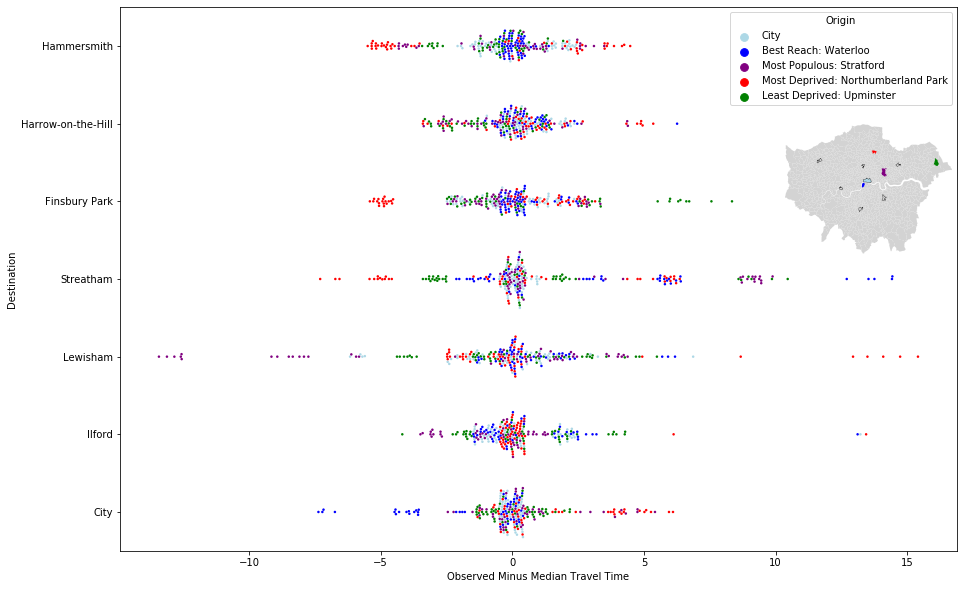

In [45]:
colours = ['lightblue','blue','purple','red','green']
fig04 = plt.figure(figsize = (15,10))
ax04_01 = fig04.add_subplot(1,1,1)
with sns.color_palette(colours):
    ax04_01 = sns.swarmplot(y = 'Destination', x = 'Observed Minus Median Travel Time', hue = 'Origin', data = swarmdata, size = 2.5)

ax04_02 = inset_axes(ax04_01, width = '100%', height = '100%', bbox_to_anchor = (.8, .55, .2, .25), bbox_transform = ax04_01.transAxes)
set_zoom(ax04_02, msoas)
msoas.plot(ax = ax04_02, color = 'lightgrey')
i = 0
for msoa in origins:
    msoas.loc[[msoa],:].plot(ax = ax04_02, color = colours[i])
    i += 1
msoas.loc[cluster_centroids,:].plot(ax = ax04_02, color = 'None', edgecolor = 'black', linewidth = .3)
plt.axis('off')

### Travel Time Variability to 7 Destinations from All Origins

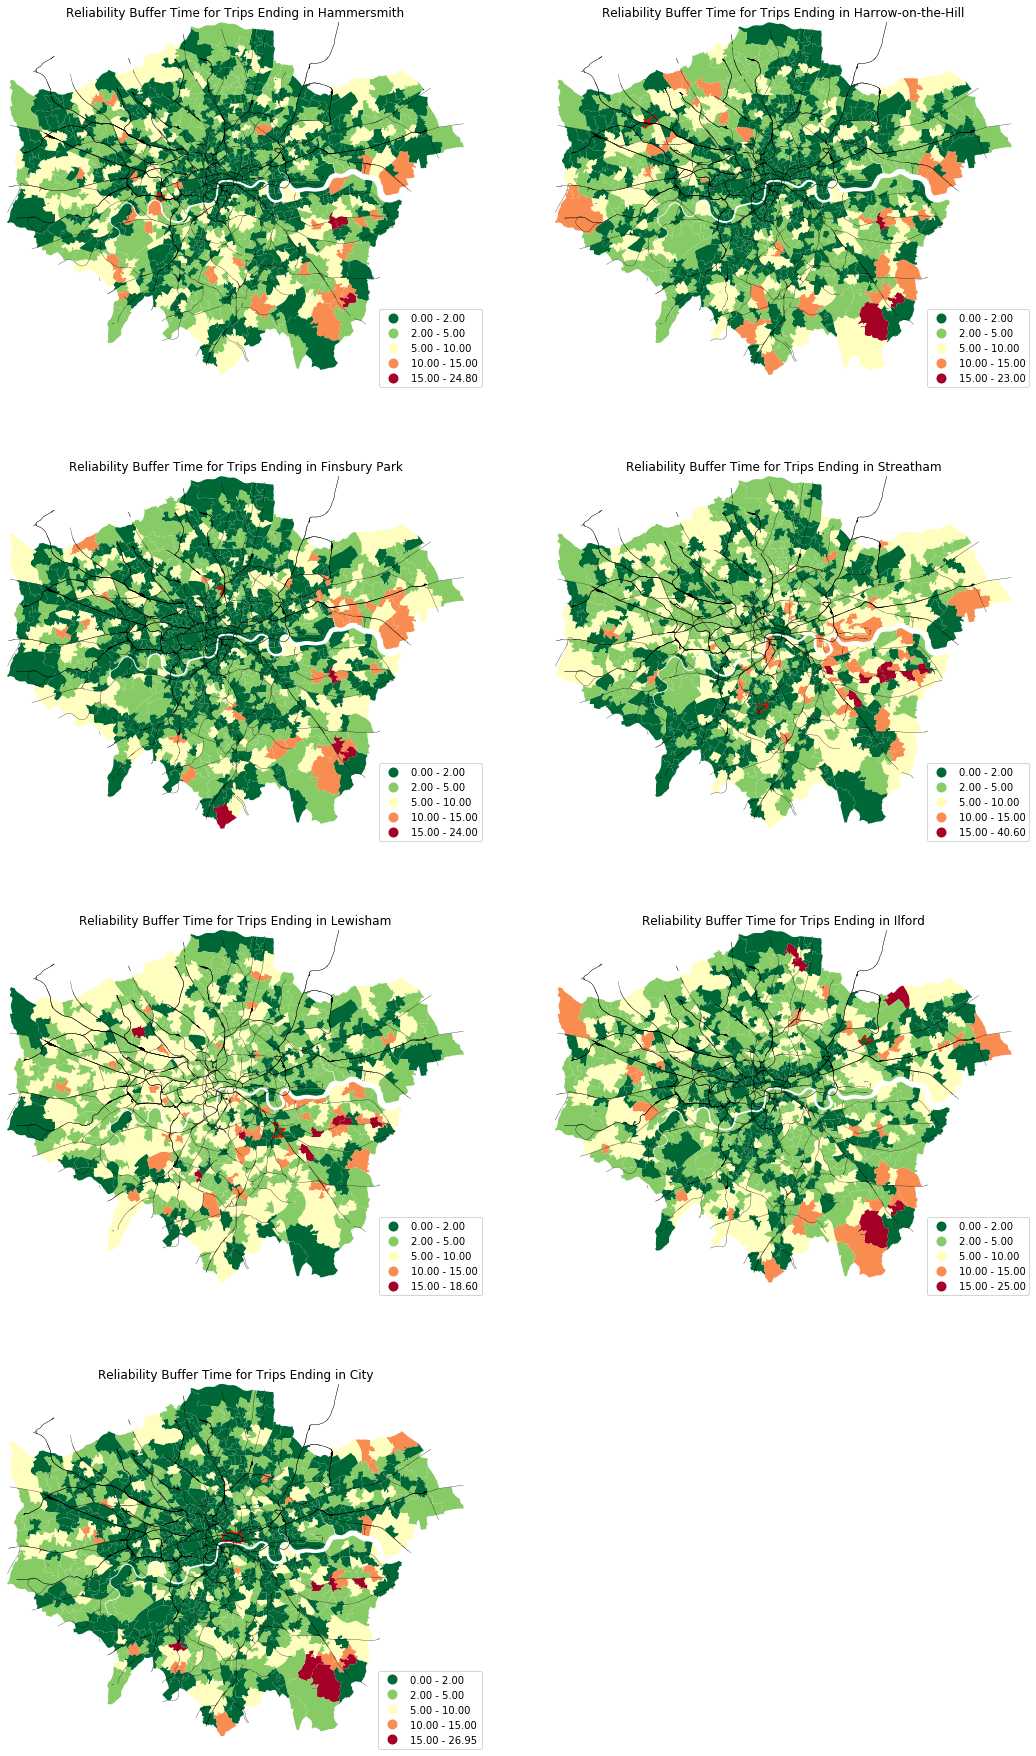

In [70]:
# plot observed variability data for trips ending in the 7 centroids
fig02 = plt.figure(figsize = (18, 8 * round(len(cluster_centroids) / 2, 0)))
for i in range(len(cluster_centroids)):
    ax02 = fig02.add_subplot(round(len(cluster_centroids) / 2, 0), 2, i + 1)
    set_zoom(ax02, msoas)
    observed_traveltimes[cluster_centroids[i]]['traveltime_variability'].plot(column = 'Range 50PC to 95PC', ax = ax02, 
                                                                              scheme = 'userdefined', 
                                                                              classification_kwds = {'bins': [2,5,10,15]},
                                                                              cmap = 'RdYlGn_r', legend = True) # 90% HPD interval width
    msoas.loc[[cluster_centroids[i]],:].plot(ax = ax02, color = 'None', edgecolor = 'red') # centroid
    londonrail.plot(color = 'black', linewidth = .3, ax = ax02)
    londontube.plot(color = 'black', linewidth = .3, ax = ax02)
    legend02 = ax02.get_legend()
    legend02.set_bbox_to_anchor((1.05, .2))
    plt.title('Reliability Buffer Time for Trips Ending in ' + centroid_names[cluster_centroids[i]])
    plt.axis('off')

### KMeans Clustering of Travel Times, Variability and IMD

In [59]:
kmeans_data = pd.DataFrame(index = msoas.index)
# for each centroid, join in baseline AM peak travel times from all MSOAs and observed 90% HPD interval width for travel times from all MSOAs
for centroid in cluster_centroids:
    kmeans_data = kmeans_data.join(ttm_baseline_ampeak.loc[:,[centroid]]).join(observed_traveltimes[centroid]['traveltime_variability'].loc[:,['Range 50PC to 95PC']])
    kmeans_data.rename({'Range 50PC to 95PC': 'Range 50PC to 95PC ' + centroid}, axis = 1, inplace = True)
# join IMD data
kmeans_data = kmeans_data.join(imd_msoa[['Index of Multiple Deprivation (IMD) Rank']])
# create standardised version of data
kmeans_data_standardised = StandardScaler().fit_transform(kmeans_data)

In [60]:
# alternative with fewer dimensions for clustering
# consider only travel time to local centroid, not to all 7 centroids
local_centroid_traveltime = pd.DataFrame()
# consider only variability to the local centroid, not to all 7 centroids
local_orig_variability = pd.DataFrame()
for i in range(len(cluster_centroids[:-1])):
    local_cluster = clustered_msoas[clustered_msoas['cluster'] == i].index
    local_centroid_traveltime = pd.concat([local_centroid_traveltime, observed_traveltimes[cluster_centroids[i]]['traveltime_variability'].loc[local_cluster, 'Median']])
    local_orig_variability = pd.concat([local_orig_variability, observed_traveltimes[cluster_centroids[i]]['traveltime_variability'].loc[local_cluster, 'Range 50PC to 95PC']])
local_centroid_traveltime.rename({0: 'Traveltime to Local Centroid'}, axis = 1, inplace = True)
local_centroid_traveltime = local_centroid_traveltime.loc[msoas.index,:]
local_orig_variability.rename({0: 'Range 50PC to 95PC to Local Centroid'}, axis = 1, inplace = True)
local_orig_variability = local_orig_variability.loc[msoas.index,:]

kmeans_data = pd.DataFrame(index = msoas.index)

# join in travel times to local centroid
kmeans_data = kmeans_data.join(local_centroid_traveltime)
# join in variability to local centroid
kmeans_data = kmeans_data.join(local_orig_variability)
# join in travel times to City
kmeans_data = kmeans_data.join(ttm_baseline_ampeak.loc[:,'E02000001'])
# join in variability to City
kmeans_data = kmeans_data.join(observed_traveltimes['E02000001']['traveltime_variability']['Range 50PC to 95PC'])
kmeans_data.rename({'E02000001': 'Traveltime to City', 'Range 50PC to 95PC': 'Range 50PC to 95PC to City'}, axis = 1, inplace = True)
# join in IMD data
kmeans_data = kmeans_data.join(imd_msoa['Index of Multiple Deprivation (IMD) Rank'])
kmeans_data_standardised = StandardScaler().fit_transform(kmeans_data)

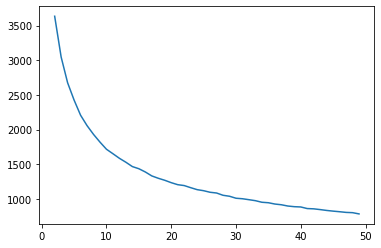

In [61]:
# identify suitable value for k
n_clusters = [i+2 for i in range(48)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [62]:
# carry out KMeans clustering
n_clusters = 7
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

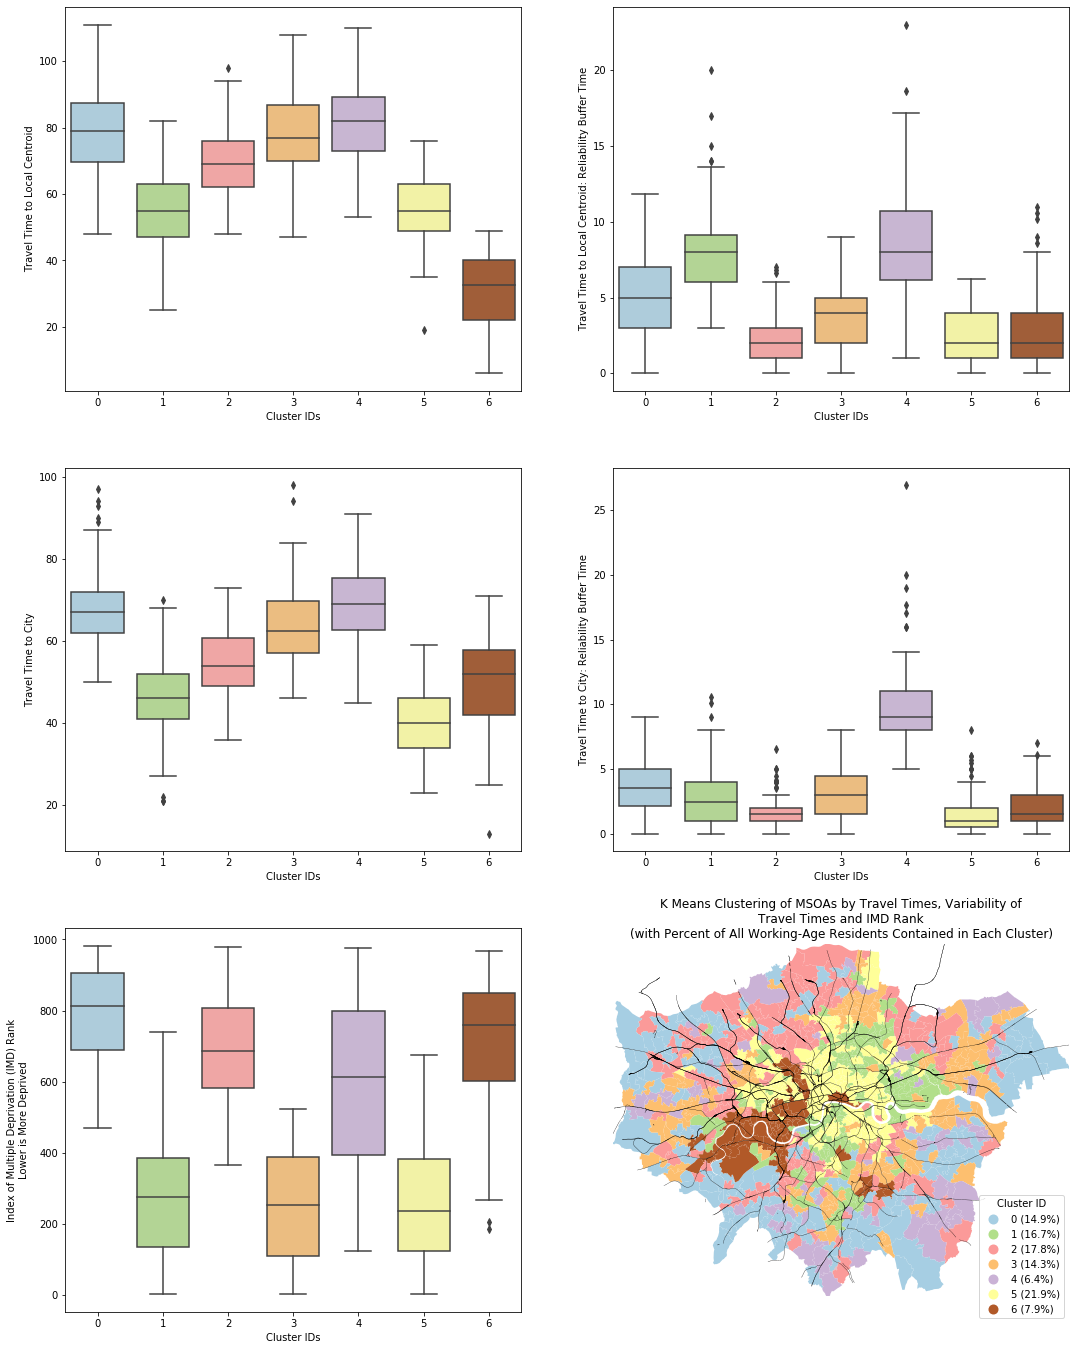

In [63]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# calculate percent working-age pop in each cluster
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
pop_per_cluster = popcounts[['Pop_WorkingAge']].join(kmeans_data['kmeans_cluster_' + str(n_clusters)])
pop_per_cluster = pop_per_cluster.groupby('kmeans_cluster_' + str(n_clusters)).sum() / popcounts['Pop_WorkingAge'].sum()
    
# plot data
fig03 = plt.figure(figsize = (18,24))

# boxplot of traveltimes to local centroid
ax03_01 = fig03.add_subplot(3,2,1)
with sns.color_palette(colormap):
    ax03_01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Traveltime to Local Centroid', data = kmeans_data)
ax03_01.set_xlabel('Cluster IDs')
ax03_01.set_ylabel('Travel Time to Local Centroid')

# boxplot of variability of traveltimes to local centroid
ax03_02 = fig03.add_subplot(3,2,2)
with sns.color_palette(colormap):
    ax03_02 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Range 50PC to 95PC to Local Centroid', data = kmeans_data)
ax03_02.set_xlabel('Cluster IDs')
ax03_02.set_ylabel('Travel Time to Local Centroid: Reliability Buffer Time')

# boxplot of traveltimes to City
ax03_03 = fig03.add_subplot(3,2,3)
with sns.color_palette(colormap):
    ax03_03 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Traveltime to City', data = kmeans_data)
ax03_03.set_xlabel('Cluster IDs')
ax03_03.set_ylabel('Travel Time to City')

# boxplot of variability of traveltimes to City
ax03_04 = fig03.add_subplot(3,2,4)
with sns.color_palette(colormap):
    ax03_04 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Range 50PC to 95PC to City', data = kmeans_data)
ax03_04.set_xlabel('Cluster IDs')
ax03_04.set_ylabel('Travel Time to City: Reliability Buffer Time')

# boxplot of IMD ranks per cluster
ax03_05 = fig03.add_subplot(3,2,5)
with sns.color_palette(colormap):
    ax03_05 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Index of Multiple Deprivation (IMD) Rank', data = kmeans_data)
ax03_05.set_xlabel('Cluster IDs')
ax03_05.set_ylabel('Index of Multiple Deprivation (IMD) Rank\nLower is More Deprived')

# clustering map
ax03_06 = fig03.add_subplot(3,2,6)
set_zoom(ax03_06, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax03_06, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax03_06)
londonrail.plot(color = 'black', linewidth = .3, ax = ax03_06)
legend03_06 = ax03_06.get_legend()
legend03_06.set_bbox_to_anchor((1,.3))
legend03_06.set_title('Cluster ID')
for i in range(len(legend03_06.get_texts())):
    legend03_06.get_texts()[i].set_text(str(i) + ' (' + str(round(pop_per_cluster.at[i,'Pop_WorkingAge'] * 100, 1)) + '%)')
plt.title('K Means Clustering of MSOAs by Travel Times, Variability of\nTravel Times and IMD Rank\n(with Percent of All Working-Age Residents Contained in Each Cluster)')
plt.axis('off')

### Write Out Useful Datasets

In [65]:
with open('../90 Data/compiled secondary data/traveltimevariability', 'wb') as outfile:
    pickle.dump(kmeans_data[['Traveltime to Local Centroid','Range 50PC to 95PC to Local Centroid','Traveltime to City','Range 50PC to 95PC to City']] , outfile)